# Introduction

We present an idea for sorting a list/array of items.

A naive first glance may lead us to believe that on average this algorithm should do better than O(nlogn). However when more thoroughly analyse we discover that although for small input sizes there is a linear improvement, as n grows large the average case approaches O(nlogn)

The version of the algorithm presented here is an O(n) space algorithm and not an in-place comparison sort. However, it does not require a RAM model or integer comparisons like radix-sort or bucket-sort.

The general idea is that we construct a new datastructure that is a list of queues that support append operations on both ends. We then process te list of items and add them to the datastructure in such a way as to optimally form queues of sorted items in O(n) time. We then do a k-way merge of those sorted queues.

The optimal way of forming queues of sorted items is to append any new items to the right of the current queue if they are larger than the right most item and to the left of the current queue if they are smaller than the leftmost item. A new queue is formed if neither of those cases is true.

The initial intuition is that forming the queues is O(n) and there will be O(k) queues where k is at most n/2 (but most probably less) and a k-way merge is O(nlogk). Therefore we must have done better than O(nlogn). As previously mentioned this intuition is only correct on a linear scale and so not true for large values of n.

When considering all permutations of items, the worst case is Theta(nlogn) but every other case is O(nlogn). 


# dynamic programming to choose what values to add to the queue 


# can we make it a true comparison sort?

# can we apply to BST?

you add each item to a data structure
- if the item can be added to either end of the current deque then do so
- else start a new deque in the ds and call it current

# use a skip list - keep list sorted up to point, binary search for index to insert

# can we make queue-sort an in-place comparison sort


In [7]:
from collections import deque, Counter


def merge(a, b):
    i, j = 0, 0
    result = []
    while j < len(b):
        if i >= len(a) or b[j] < a[i]:
            result.append(b[j])
            j += 1
        else:
            result.append(a[i])
            i += 1
    return result


class Sorter():
    
    def __init__(self):
        self.ds = [deque()]
        
    def insert(self, item):
        if not self.ds[-1] or item > self.ds[-1][-1]:
            self.ds[-1].append(item)
        elif item < self.ds[-1][0]:
            self.ds[-1].appendleft(item)
        else:
            self.ds.append(deque([item]))
    
    def mergek(self):
        if len(self.ds) == 0:
            return
        ds = self.ds
        while len(ds) != 1:
            self.ds = []
            for i in range(0, len(ds), 2):
                self.ds.append(merge(ds[i], ds[i+1]) if i < len(ds)-1 else ds[i])
            ds = self.ds

A helper function to create plots.

In [12]:
import matplotlib.pyplot as plt


def plot_function(xs, ys, title="", xlabel="", ylabel=""):
    fig, ax = plt.subplots()
    ax.plot(
        xs, 
        ys)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()


## Rough Benchmark of Sort vs Python Standard Library Sort

In [59]:
import time
from itertools import permutations
import random


def benchmark_sorter(list_size):
    st = time.perf_counter()
    i = 0
    base_list = list(range(list_size))
    for i in range(10000):
        random.shuffle(base_list)
        s = Sorter()
        for c in base_list:
            s.insert(i)
        s.mergek()
        i += 1
    e = time.perf_counter()
    return e-st


In [60]:
import time
from itertools import permutations


def benchmark_python(list_size):
    s = time.perf_counter()
    i = 0
    base_list = list(range(list_size))
    for i in range(10000):
        random.shuffle(base_list)
        a = sorted(base_list)
        i += 1
    e = time.perf_counter()
    return e-s


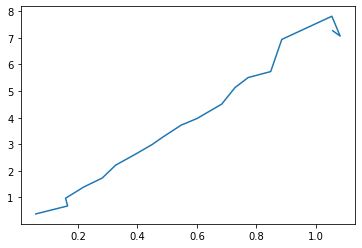

In [61]:
ys = []
xs = []
for i in range(10, 200, 10):
    ys.append(benchmark_sorter(i))
    xs.append(benchmark_python(i))
plot_function(xs, ys)

### How does sort-by-queues do relative to an 'nlogn' sort

Sort-by-queues takes O(n) to create the queues but the number of queues will vary depending on the input. Given that we can merge k lists in nlogk the final runtime complexity of sort-by-queues depends on how many queues are created. In this section we do a brief analysis of how the average number of queues `k` and compare `log(k)` to `log(n)`.

In [51]:
from itertools import permutations


def get_counts(length):
    c = Counter()
    for p in permutations(range(length)):
        s = Sorter()
        for i in p:
            s.insert(i)
        c[len(s.ds)] += 1
    return c

ratios = []
for i in range(1,10):
    counts = get_counts(i)
    tot = sum( (math.log(k,2)*v for k,v in counts.items()))
    logk = tot/math.factorial(i)
    logn = math.log(i, 2) if i >1 else 1
    print(counts)
    print("ratio", logk/logn)
    ratios.append(logk/logn)
    


Counter({1: 1})
ratio 0.0
Counter({1: 2})
ratio 0.0
Counter({1: 4, 2: 2})
ratio 0.21030991785715245
Counter({2: 16, 1: 8})
ratio 0.3333333333333333
Counter({2: 92, 1: 16, 3: 12})
ratio 0.3984459806381999
Counter({2: 464, 3: 224, 1: 32})
ratio 0.4400620468559583
Counter({3: 2644, 2: 2184, 4: 148, 1: 64})
ratio 0.47145440755269036
Counter({3: 25296, 2: 9856, 4: 5040, 1: 128})
ratio 0.4962732425449931
Counter({3: 214464, 4: 101792, 2: 43248, 5: 3120, 1: 256})
ratio 0.5163805807955659


The cost of computing the relative performance for input lengths greater than 11 is too high. We will approach the problem by taking a random sample of permutations

In [49]:
from itertools import permutations


def get_counts_sample(length, num_samples):
    c = Counter()
    base_list = list(range(1, length + 1))
    for i in range(num_samples): #p in permutations(range(length)):
        random.shuffle(base_list)
        s = Sorter()
        for i in base_list:
            s.insert(i)
        c[len(s.ds)] += 1
    return c

# LONG RUNNING CODE - precomputed below
#
# ratios_10_to_100 = []
# for i in range(12,100):
#     counts = get_counts_sample(i, 100000)
#     tot = sum( (math.log(k,2)*v for k,v in counts.items()))
#     logk = tot/100000
#     logn = math.log(i, 2)
#     ratios_10_to_100.append(logk/logn)

# PRECOMPUTED
ratios_10_to_100 = [0.533140655409678, 0.5474314348165317, 0.5594472814446738, 0.5709016441064565, 0.5803107374506197, 0.5890941127142336, 0.5965276962824045, 0.6040833596052821, 0.6102222412401676, 0.6163273283175222, 0.622012130634089, 0.6270609012966123, 0.6318613184083582, 0.6362702912151057, 0.6404029861992977, 0.6442894498533058, 0.6482601527326678, 0.651874225327803, 0.6549990188211892, 0.6582308933601062, 0.6611269783432325, 0.6637689198571304, 0.6668065056610766, 0.6691928083549754, 0.6719526924515266, 0.6741128835958506, 0.6765592957297009, 0.6786874028792637, 0.6804823549733964, 0.6828516136638654, 0.6848688676440978, 0.6866160145207253, 0.6882319843024224, 0.6902752888631787, 0.6919936813182203, 0.6937594267383982, 0.6952541540951938, 0.696708554124006, 0.6982829764179193, 0.6997363495008876, 0.7012853471636641, 0.7025470142143618, 0.7039309923176622, 0.705148726129963, 0.7065159438116271, 0.7077092012382472, 0.7089321146303637, 0.7101045092741557, 0.711255400704244, 0.7122338193615341, 0.7133705336090861, 0.7145474564033693, 0.7156081515338488, 0.716540590271144, 0.7175418368700944, 0.7186003384584592, 0.7195528858464499, 0.7205393125851836, 0.7213228493285243, 0.72237932355555, 0.7231958271743769, 0.7241207925791647, 0.7249125342316864, 0.7256713204462151, 0.7265203481355702, 0.7273286198857573, 0.728188927301463, 0.7288849734080315, 0.7296629068331169, 0.7304950659162588, 0.7310848745385673, 0.7317811220212933, 0.7325820468902026, 0.7332685853135632, 0.7338414244343464, 0.7345432718995404, 0.7352551332466489, 0.7358677978555509, 0.7364346994859728, 0.7371168076023676, 0.7377261899275168, 0.7383453281329937, 0.7389186450194019, 0.7394851942134499, 0.7401483067216076, 0.7407067154078647, 0.7412163874849477, 0.7418163526177826, 0.7424625610325575, 0.7429147260826008]

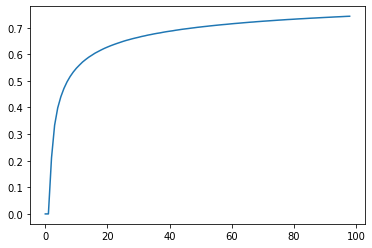

In [52]:
all_ratios = ratios + ratios_10_to_100
plot_function(range(len(all_ratios)), all_ratios)

Let's zoom out a bit

In [77]:

# LONG RUNNING CODE - precomputed below
#
# ratios_100_to_10000 = []
# trials = 1000
# for i in range(100,10000,200):
#     counts = get_counts_sample(i, trials)
#     tot = sum( (math.log(k,2)*v for k,v in counts.items()))
#     logk = tot/trials
#     logn = math.log(i, 2)
#     ratios_50_to_1000.append(logk/logn)
#     print(i, ratios_100_to_10000[-1], end=" ")
# print()
# print(ratios_100_to_10000)

# PRECOMPUTED
ratios_100_to_10000 = [0.7435188917844668, 0.7912914039072104, 0.8083028326564489, 0.8180772184216755, 0.824761130148988, 0.8296369193091881, 0.8336187942767869, 0.8368686699666862, 0.8395226155075796, 0.8419193033136153, 0.8440290697714874, 0.8458032550194391, 0.8474737785682188, 0.8488549372534505, 0.850266968708888, 0.8515339748267394, 0.8526056919045018, 0.8537132697692204, 0.8547556614712053, 0.8556223141437804, 0.8565208815251366, 0.857305023386406, 0.858090537016405, 0.8588003157033838, 0.8595234837547951, 0.8601527214763202, 0.8608160377653411, 0.8613380995570887, 0.8619977514357787, 0.8624836970864538, 0.863023523549754, 0.8635562899048698, 0.8640334142786823, 0.864514106591703, 0.8649384443428468, 0.8652982113911186, 0.8657555645920039, 0.8662128193443533, 0.8665682980515801, 0.8669709535689533, 0.8673694819351296, 0.8677027427485383, 0.868033020800884, 0.8683602061811344, 0.8687316992013866, 0.8690274719026654, 0.8693329994365412, 0.8696256241940108, 0.8699445352593103, 0.8702537250704716]

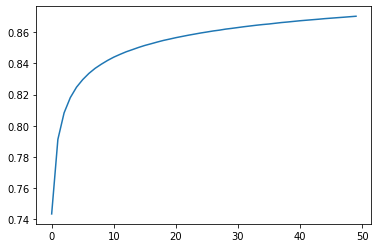

In [78]:
plot_function(range(len(ratios_100_to_10000)), ratios_100_to_10000)

This curve looks like is approaching 1. I.E. that the `log(number of queues)` is approaching `log(n)`. We know that the number of queues in the worst case will be `n/2` and the `log(n/2)` is equal to `log(n)-1`. Certainly if the average case was equal to the worst case we would expect `log(number of queues)` to approach `log(n)` for large n. But there shoudl be many better cases than the worst case so why do we see this behaviour?

# How is the number of Queues Inherent in a Given Permutation Distributed?

Below we graph the distribution of the number of queues in 100,000 random sample permutations of a list of length 100. We find that that the distribution looks similar to a binomial or normal distribution and that the center of the distribution is at approximately 30 (i.e. the most commone value for the lengths of the queues is around the value 30).

If we assume this curve is normal then we can conclude that k (the number of queues) is O(n) and so for larger numbers of n, `log(k)` will approach `log(n)`

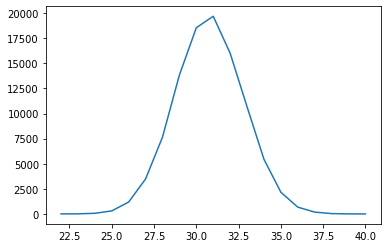

In [54]:
c100 = get_counts_sample(100, 100000)
c100 = [(k,v) for k,v in c100.items()]
c100.sort()
plot_function([k for k,v in c100], [v for k,v in c100])

In [162]:
def f(a):
    mx = a[0]
    mn = a[0]
    results = [(a[0], a[0])]
    for i in range(1, len(a)):
        if a[i] > results[-1][0]:
            results.append((a[i], results[-1][1]))
        elif a[i] < results[-1][1]:
            results.append((results[-1][0], a[i]))
        else:
            results.append((results[-1][0], results[-1][1]))
    return results

print(f([1,2,3,4,5]))
print(f([3,1,4,2,5]))

[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
[(3, 3), (3, 1), (4, 1), (4, 1), (5, 1)]


do the opposite to build BST - if its in the middle put it at the end, if its at the end start a new one